# [Great Energy Prediction](https://www.kaggle.com/c/ashrae-energy-prediction/overview) - Data Exploration
--- 

In this noteboook, we'll take a closer look at the great energy prediction data.

## Python Libraries
First of all, we need to import some libraries that allows us to work with and visualize the data. 

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from utils.load_data import load_data

## Loading Data

In [2]:
train, test, weather, building_information = load_data()

---
# Train & Test

The train and test have the same features, apart from `meter_reading` which is what we want to predict. Let's start by looking at some key information regarding these DataFrames.

In [10]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


The tree columns we have (apart from the target `meter_reading`) are:
- **`building_id`** - which building we're looking at
- **`meter`** - which type of energy consumption meter we're reading
- **`timestamp`** - when we record the reading

Let's continue by looking at the amount of data we have...

In [7]:
print('Number of rows in train: {}'.format(len(train)))
print('Number of rows in test: {}\n'.format(len(test)))

print('Number of buildings in train: {}'.format(len(train.building_id.unique())))
print('Number of buildings in test: {}'.format(len(test.building_id.unique())))

Number of rows in train: 20216100
Number of rows in test: 41697600

Number of buildings in train: 1449
Number of buildings in test: 1449


We see that the test dataset actually contains twice the amount of data, which is very uncommon. We also have a lot of data, 40M rows for test, and 20M rows for train. Note also that the datasets contains the same number of buildings. Let's see if they contains the exact same buildings:

In [9]:
print('Number of buildings in train that does not exist in test: {}'.format(
    len(train[~train.building_id.isin(test.building_id)].building_id.unique())
))

Number of buildings in train that does not exist in test: 0


Ok, so we have the same buildings in both train and test. Next, we take a quick look at the timestamps.

## `Timestamp` in train & test

In [11]:
print('The training data starts at {} and ends at {}'.format(train.timestamp.min(), train.timestamp.max()))
print('The testing data starts at {} and ends at {}'.format(test.timestamp.min(), test.timestamp.max()))

The training data starts at 2016-01-01 00:00:00 and ends at 2016-12-31 23:00:00
The testing data starts at 2017-01-01 00:00:00 and ends at 2018-12-31 23:00:00


So, we have one year of data to train on and two years of data for testing. That's pretty interesting because it means that if we want to split the data for validation in accordance to the task we should split on date. The problem is that we won't be able to capture yearly pattern during training.

If we plot the 5 smallest `timestamp` values, we see that we're working with hourly data.

In [16]:
list(train.timestamp.unique())[:5]

[numpy.datetime64('2016-01-01T00:00:00.000000000'),
 numpy.datetime64('2016-01-01T01:00:00.000000000'),
 numpy.datetime64('2016-01-01T02:00:00.000000000'),
 numpy.datetime64('2016-01-01T03:00:00.000000000'),
 numpy.datetime64('2016-01-01T04:00:00.000000000')]

## Potential values for `meter`

Let's not look at `meter`. First of all, according to the competition information we have four different meters: `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. But not every building has all meter types.

---
# Building Information

Next up we have building information. Here we have 5 features in addition to `building_id`. They are:

- **`site_id`**
- **`primary_use`**
- **`square_feet`**
- **`year_built`**
- **`floor_count`**

The most exciting field is the `site_id` because it gives us a location that we can connect with the weather data. The other information is relevant in terms of energy consumption, but we will most likely use  `building_id` as a categorical feature during training and information such as `square_feet` might be obsolete.

In [22]:
building_information.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


## Information about `site_id`

Let's start by looking at how many building we have at the different sites:

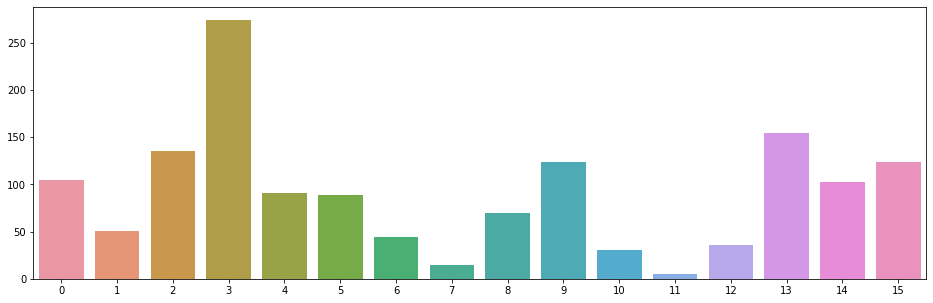

In [26]:
building_counts = building_information.groupby('site_id').count()['building_id']

plt.figure(figsize=(16, 5))
sns.barplot(y=building_counts.values, x=building_counts.index.values)
plt.show()

We can clearly see that the dataset is unbalanced in terms of the number of buildings for each site. This might be a problem, but probably not, since buildings should consume energy independently of each other.

## Information about `primary_use`

Let's also look at primary use, since that should have an impact on when the building consumes the most energy.

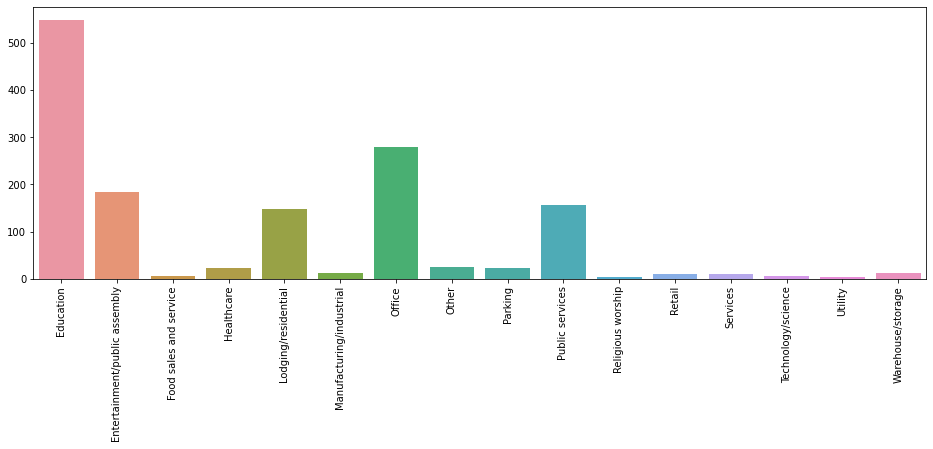

In [29]:
building_counts = building_information.groupby('primary_use').count()['building_id']

plt.figure(figsize=(16, 5))
graph = sns.barplot(y=building_counts.values, x=building_counts.index.values)
graph.set_xticklabels(graph.get_xticklabels(), rotation=90)
plt.show()

---
# Weather Data

Weather data should be very important for energy consumption. Since the goal of this project is to build good models on historical data for the present, we actually have access to weather data for testing. A very uncommon situation when working with timeseries.

In [30]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


The information we have access to is:

- **`air_temperature`**
- **`cloud_coverage`**
- **`dew_temperature`**
- **`precip_depth_1_hr`**
- **`sea_level_pressure`**
- **`wind_direction`**
- **`wind_speed`**

Some of these will, of course, be more important than others. For example, `wind_direction` should have a minimal impact compared to `air_temperature`.

## `site_id` and strange patterns

One thing I notices when looking at the weather data is that the timestamp doesn't seem to be in local time. If we plot the average hourly temperature, we expect the peaks to be roughly at the same time for every site, but that's not what happens:

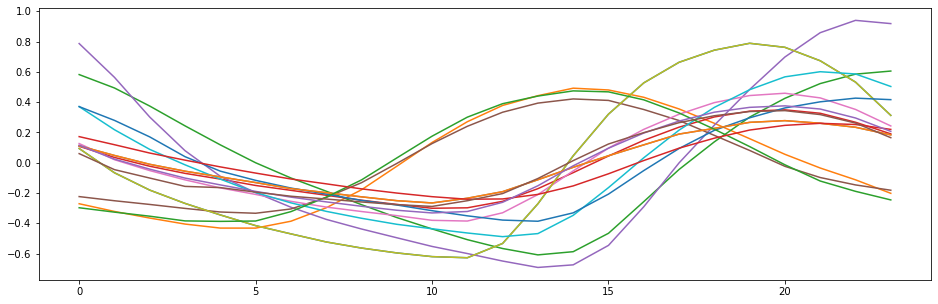

In [32]:
plt.figure(figsize=(16, 5))

for site_id in weather.site_id.unique():
    site_weather = weather[weather.site_id == site_id].copy()
    site_weather.air_temperature -= site_weather.air_temperature.mean()
    site_weather.air_temperature /= site_weather.air_temperature.std()
    site_weather['hour'] = site_weather.timestamp.dt.hour    
    sns.lineplot(y=site_weather.groupby('hour').mean()['air_temperature'].values, x=[i for i in range(24)])
    
plt.show()

We can see that some sites have their peak at 14-15, which seems reasonable, but other sites peaks at 20 or even 23. That's obviously wrong, and I take care of that in the Preprocessing notebook.

---
# What about the `meter_reading`

The most essential part of our data exploration is to understand the targer variable. Unfortunatly, it's clear that there's a lot of noise in the readings that we need to consider before training (see Preprocessing notebook).

One thing that's special here is that many of the anomalies are sporeadic and probably occurs in the test dataset as well. We need to decide how much preprocessing we can do without hurting the performance on the test set. In reality, we probably want to clean the testset as well, but since this is a competition, we don't have that luxury.

Here's a couple of examples of anomalies in the `meter_reading`:

In [33]:
from utils.plotting import plot_lines

## Bad starts of the sequence

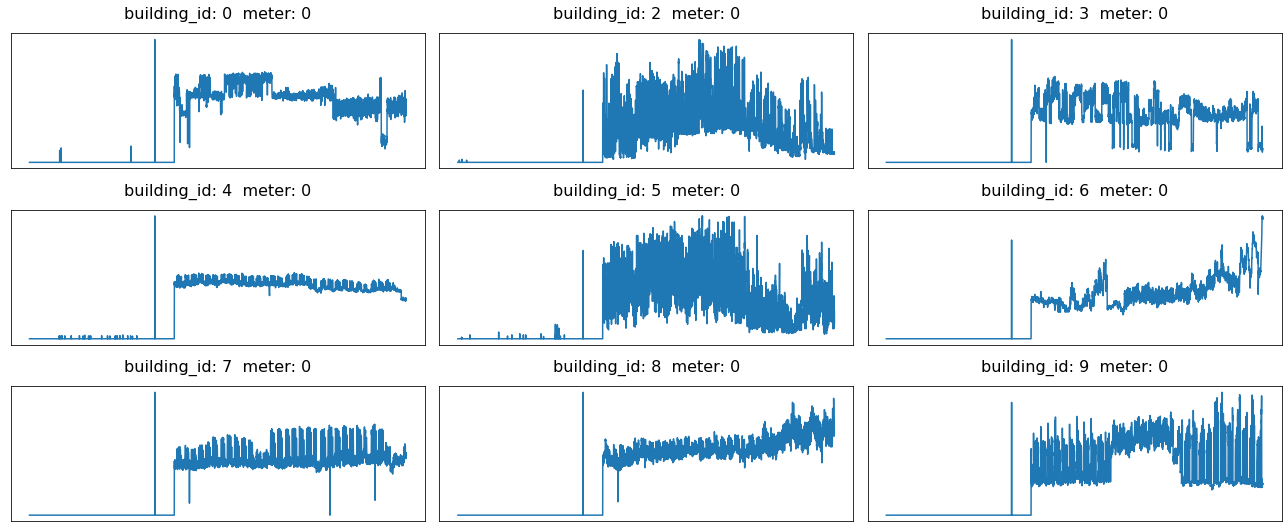

In [34]:
plot_lines(train, [0, 2, 3, 4, 5, 6, 7, 8, 9])

## Strange sub-sequences of constant values

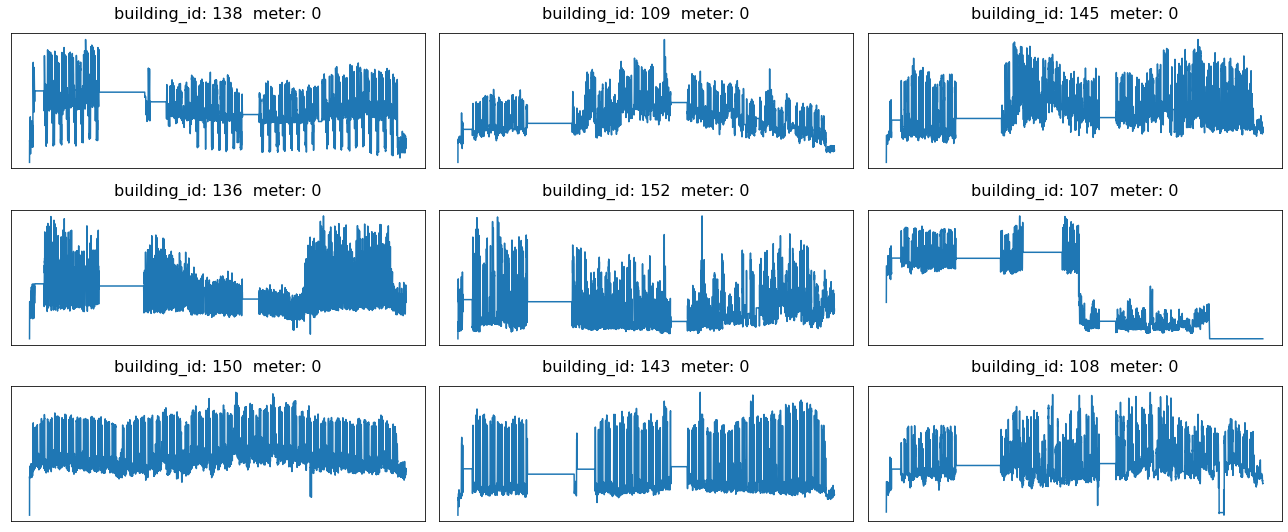

In [36]:
plot_lines(train, [138, 109, 145, 136, 152, 107, 150, 143, 108])

## Different values for each building

The `meter_reading` values are not normalized and can be much larger for one building compared to another. Instead of normalizing the values for each building, the compition uses RMSLE as metric where the logging makes all values more similar to each other.

Since we will use `building_id` during training, we don't need to do anything about that.